## 12.U-Net（2015年）

**学习目标：**

1. 理解医学图像分割的目的

2. 理解U-Net模型的架构

3. 理解DICE损失函数

4. 学会使用预训练模型分割脑肿瘤图像

***

U-Net是一种深度学习网络结构，最初是为了解决医学图像分割问题而设计的。它由 Olaf Ronneberger、Philipp Fischer 和 Thomas Brox 在 2015 年的论文《U-Net: Convolutional Networks for Biomedical Image Segmentation》中提出。之后被用于stable diffusion等生成式人工智能模型架构中。

以下是 U-Net 的一些关键特点：

对称的 U 形结构：U-Net 的结构呈对称的 U 形，包括一个收缩（编码）路径和一个对称的扩展（解码）路径。

编码器（收缩路径）：编码器部分由多个卷积层和池化层组成，用于逐步降低图像的空间维度，同时增加特征通道数，捕捉上下文信息。

解码器（扩展路径）：解码器部分由上采样（或转置卷积）和卷积层组成，用于逐步恢复图像的空间维度，同时减少特征通道数。

跳跃连接（Skip Connection）：U-Net 通过跳跃连接将编码器中的特征图与解码器中的对应层级直接相连，这有助于在图像分割中保留更多的位置信息。

多尺度特征融合：跳跃连接实现了不同尺度的特征融合，有助于精确地定位感兴趣的区域。

适用于医学图像分割：U-Net 的设计特别适合处理医学图像，如细胞、组织和其他生物结构的分割。

可扩展性：U-Net 的基本架构可以扩展到其他类型的图像分割任务，包括但不限于医学图像。

数据效率：U-Net 能够在相对较少的标记数据上进行训练，这在医学图像领域尤为重要，因为获取大量标记数据可能成本高昂。

变体和发展：自 U-Net 提出以来，已经出现了许多变体和改进，以适应不同的应用场景和提高性能。

多任务学习：U-Net 可以扩展为多任务学习模型，同时执行分割和其他任务，如分类。

U-Net 的成功在于其能够有效地结合图像的上下文信息和位置信息，这使得它在图像分割领域非常流行，特别是在需要精确定位的医学图像分割任务中。此外，U-Net 的架构也启发了其他领域的网络设计，如在自然语言处理中的 Transformer 模型中的注意力机制。

### 17.1  项目背景

图像分割（Segmentation）是计算机视觉研究的重要领域之一，其任务是使用图像作为输入，为图像中的每个像素分配一个类。对于医学图像的分割即给定的图像是在生物医学领域中的医疗影像图，例如CT，X光，核磁共振影像等等，而分割的目标在于问题的定义，可以是一个病灶，一个器官或是多个细胞组织。

下图显示了目前最热门的不同分割任务的分支，如血管分割、皮肤病灶分割，肺部分割，细胞核分割。血管的分割将有助于检测和治疗影响血管的许多疾病。 视网膜血管的宽度和曲线显示出许多疾病的一些症状。 许多威胁视力的疾病的早期诊断至关重要。皮肤病灶分割有助于早期发现和诊断皮肤癌。 肺分割的任务是从肺 CT 图像上的周围胸组织中识别肺的边界，是肺医学影像分析中重要的第一步，它也可以应用于肺癌分割。 细胞核分割，是通过显微镜下成像，细胞核进行分割，我们已知的生物生命都包括一个称为细胞的基本单位通过此操作，可以了解细胞核和细胞所含DNA在各种处理中的作用和功能。

<center size=50>
<img src="./images/U-Net/segmentation.png" style="zoom: 70%;" />
</center>

### 17.2  什么是医学图像分割？

图像分割任务的定义是：将照片中的全部部分 $\Omega$ 分割成不同的一个或N小部分$\Omega_1, \Omega_2, \Omega_3,... \Omega_N$, 其中所有的小部分不重叠（即交集为空集）而且并集是全集$\Omega$， 通过数学表达式可以写成：
$$
\bigcup_{i=1}^n \Omega_i = \Omega \\
\Omega_i \bigcap \Omega_j = \empty, i \ne j \in{1,2, ...N}
$$
<center size=50>
<img src="./images/U-Net/segmentation2.png" style="zoom: 40%;" />
</center>

医学图像就自然图像的分割，有着相同之处，但也有这不同点：

a）医学图像通常分辨率比较高，而且通常是三维的，通过神经网络对于医学图像做训练，非常**消耗内存**，通常需要性能比较优越的GPUs来辅助，否则会出现cuda out of memory的问题。

b）分割任务需要分割的部位，尤其是病灶分割，目标类别通常非常小，而且对于一个三维的医学图像而言，并不是每个切片上都存在需要分割的前景，可能绝大多数图像都是没有目标类别的背景。因此这样非常严重的**类别不平衡**现象，也是一个重要的医学分割难点。

c）医学图像的分割可以加入很多**先验知识**，例如对于脊柱的分割，很有可能脊柱部位的医学影像中，脊柱通常位于影像的中间部位，此时可以加入中间轴的位置信息，作为分割的先验条件，改善最终的分割结果。

d）不同型号的医疗设备产生的**噪声**也不同，而且医学图像中引入的噪声往往不是普通的高斯分布的噪声。

e）医学图像训练过程中，非常缺少**准确标注的数据**，更需要一些非监督或是弱监督的算法来实现分割任务，否则通过医生花费大量时间进行目标标注也是对医疗资源的浪费。

### 17.3  U-Net模型结构和原理

1、网络架构

在医学图像分割任务中，U-Net结构是最著名的网络结构之一，该模型建立在FCN的架构之上，也因为整个网络架构如同U型而被取名为UNet。UNet同样可以理解为一个编码/解码器，其创新之处除了增加了网络的深度之外，还通过加入跳跃链接（skip-connection）的操作，使得这些连接为反卷积层提供了基本的高分辨率特征。Unet在医学图像分割中效果非常优越，通常作为各个不同任务的基线（baseline）。因此在本项目肿瘤分割的任务中，我们也采用此网络进行演示。

UNet包括三个组成部分，即主干特征提取网络，加强特征提取网络以及预测网络。

**主干特征提取网络**：此部分目的是在于特征的提取，通过设计与VGG相似的特征提取部分，包括卷积和最大池化的堆叠。利用主干特征提取部分我们可以获得五个不同维度的初步有效特征层，为下一步特征融合进行铺垫准备。

**加强特征提取网络**：通过主干特征提取网络中五个不同下采样维度得到的特征图，通过跳跃连接（skip-connection），以级联的方式融合到上采样的输入中，进行特征融合，获得一个最终的，融合了所有特征的有效特征层。

**预测网络**：预测网络可以根据最终任务目的进行修正。对于分割任务而言，得到的结果是一个分割掩模，即对有效特征层上对每一个像素点进行分类。

<img src="./images/U-Net/unet.png" style="zoom: 40%;" />

2、损失函数

由于医学图像分割任务的特殊性，许多对于传统自然图像的分割网络设计，需要针对医学图像分割的特殊性进行修正，对网络架构或是损失函数进行重新定义，才能更好的符合该任务的要求，在本次任务中，训练的网络就是基于医学图像的特殊性进行特殊调整后训练的，目的是针对医学图像中类别不均衡的问题，选择更加合适的损失函数进行训练。如下图举例所示，对于左图自然图像中的分割任务中，飞机的目标前景非常大，占据了很多像素点；而在右图的医疗图像分割任务中，肿瘤部位的部分非常小，而且在其他的切片中可能都不含邮肿瘤信息，整张照片都是背景图。这样在医学图像中非常类别不均衡的问题，如果只用简单的二值交叉熵损失函数，就无法很好的得到最终的分割结果，而通过平均交并比/DICE损失函数，才能更有效的学习。

<img src="./images/U-Net/segmentation1.png" style="zoom: 40%;" />

简单的原因如下：对于二值交叉熵损失函数而言，如果一个图中需要分割的前景很小，由于简单的二值交叉熵函数只在意像素分类的正确性，如果网络将最终结果全部分类为背景图，也可以得到一个很不错的精度，然后这造成了网络性能的退化。而平均交并比或是DICE损失函数，更在意预测的重叠部分，如果全部定义为背景图，那与真实值重叠部分就是空集，完全得不到理想的结果，具体损失函数如下进行更细致的讲解：

<img src="./images/U-Net/segmentation3.png" style=" zoom:40%;" />

IOU交并比/DICE损失

因此后来学者们提出另一种基于重叠的损失函数——交并比/DICE损失函数。这两种损失函数的定义大致时完全相同的，只是IOU损失计算交集时取的是集合A和集合B的交集，计算并集的时候选取的是集合A和集合B的并集，而DICE损失函数在计算交集时选取的是两倍的集合A和集合B的交集，计算并集的时候选取的是集合A和集合B的和，因此两倍的交集为了补偿集合之和中产生的重叠部分，使得最终结果在[0,1]之间。由于在数学定义上和使用限制上没有很大的差异，这里我们最终选择DICE损失函数进行介绍，在项目中训练模型也使用到了DICE损失函数。

<img src="./images/U-Net/dice.png" style="zoom: 40%;" />

对于DICE损失而言，他对于大小前景是非常敏感的，在上图举例中可以看出同样是一个假阴性和一个假阳性判断的像素点，对于前景小的分割任务，造成的损失函数是很大的，因此DICE损失函数通过重叠的思想，使得结果对于小前景的分割任务性能可以更加优越。然而DICE损失函数也有他的不足之处，对比于上图中最后一列来看，如果我们下一次预测得到的结果中只含有一个假阴性的数据了，此时对于二值交叉熵而言，损失函数还是一个平滑的变动（如果我们定义两次的概率是相同的，那BCE也会是一个相同的值）。然而当我们看DICE损失的变化时，我们可以发现，对于小前景的问题上，DICE损失的变化时很大的从0.5变为了0.34，这样的跳变会对反向传播有不利的影响，使得训练不稳定。

因此可以看出BCE损失和DICE损失在具体应用中都有其优点和缺点，一个基线（baseline）的方式就是同时计算BCE和DICE损失函数，通过参数调节两种损失的权重大小，之后也有更多的研究探索

2、评价指标（或许这部分就给一个实验结果，并对其分析？）

预训练的Unet模型，可以进行模型的推演，最终得到分割后的结果。首先我们看一下本次项目需要实现分割的带有肿瘤的核磁共振图像，从下图可以看出，图像中脑部左上方有一块不符合其他区域的肿瘤部分，也是本次脑肿瘤分割任务需要得到分割结果的部分。

<img src="./images/U-Net/t1.png" style="zoom: 60%;" />

接下来我们来看一下通过Unet模型进行模型推演之后得到的结果。可以看出通过Unet分割网络得到的分割结果是一个与原核磁共振图像大小相同的的掩码图像，掩码结果是一个像素值为0和1的图像，0表示背景，1表示前景，也就是需要分割的肿瘤部分。此处需要注意对于图像格式的文件而言，像素值的大小是0-255，因此如果直接可视化掩码（像素值是0，1）会是一张全黑的图像，需要将掩码乘以255才能通过图像显示掩码的效果。

<img src="./images/U-Net/pred.png" style="zoom: 60%;" />

最后我们来看一下在原本的数据集中给出的分割‘金标准’，也就是通过医生手动分割的肿瘤掩码。从肉眼可以看出，最终通过UNet训练得到的掩码结果和医生分割的结果还存在着比较大的差异，原因是目前我们使用的是最基本的UNet模型和最基础的DICE损失函数，在目前辅助医疗工业级产品中，还会有更好的模型设计，例如DenseUNet，UNetr等等，以及更优化的损失函数，例如TverskeyLoss，FocalLoss等等的损失函数对分割结果进一步优化，有兴趣的同学也可以自行阅读相关知识。

<img src="./images/U-Net/gt.png" style="zoom: 60%;" />

在医学中对于分割结果我们还需要做进一步的分析和评价，来体现模型的优越性。对于分割模型而言，有两种常见的评价指标，其一基于像素点分类情况的，另一个是基于重叠区域的

1. PA（pixel accuracy）是基于像素点分类结果的评价指标，考虑每个像素点是否判别到正确的类别中，来计算分割的精确度。简单通俗的理解就是正确分类的像素数量占总像素数量的比例。举例：对于一张分辨率为20*20的图像而言，如果有100个像素的分割类别是正确的，PA=100/(20$\times$20) = 100/400 = 25%

   然而PA的问题在于当需要分割的部分很小时，并不能很好地评价模型。举例：同样对于一张分辨率为20*20的图像，需要分割的是一个极小的部分，只有4个像素，背景将会是非常大的部分，是 20$\times$20-4 = 396个像素，如果模型全部预测了背景，也就是396个像素是正确的，4个像素是错误的，此时PA=396/(20$\times$20)$\approx$100%。可以看出通过PA这一评价指标，模型的效果近似完美，然而从问题本省出发，需要分割得到的极小前景区域却完全没有预测得到，此模型完全没有效果。

   由此可见虽然PA的计算和理解非常简单，但是在医学中分割任务通常是比较小的区域，尤其是病灶分割，对于需要分割区域比较小的任务而言，PA并不是一个很好的评价指标。

2. IOU（intersection over unit）是基于重叠区域的评价指标，考虑对于需要分割的部分的真实掩码和预测掩码的重叠区域的占比大小，具体计算公式是：$IOU=\frac{交集}{并集}=\frac{TP}{FN+TP+FP}$，具体TP，FN，FP的定义之后将通过脑肿瘤分割任务来进行具体介绍。

<img src="./images/U-Net/iou.png" style="zoom: 60%;" />

   浅灰部分：TP（真阳性），表示预测是肿瘤，而且实际也是肿瘤的部分

   深灰部分：FP（假阳性），表示预测为肿瘤，而实际不是肿瘤的部分

   中灰部分：FN（假阴性），表示预测为非肿瘤，而实际是肿瘤的部分

   对此情况，具体而言IOU的计算公式将是：$\frac{浅灰部分}{浅灰部分+中灰部分+深灰部分}$

<img src="./images/U-Net/overlap.png" style="zoom: 60%;" />

为什么IOU评价指标对小区域分割任务更加适合呢？

同样通过之前的例子进行举例：对于一张分辨率为20*20的图像，只有4个像素是肿瘤部分，则背景是 20$\times$20-4 = 396个像素，如果模型全部预测为背景，那么TP部分就是0，因此整个IOU评价指标就是0，表明模型预测非常差。这是符合事实情况的评价，因为模型对于小的肿瘤部分，完全没有预测正确。

### 17.4  基于U-Net的脑肿瘤图像分割代码实现

**1. 导入相关的依赖模块**

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import img_as_ubyte
import torch
from torchvision import transforms
from models.unet import UNet

**2. 预训练模型的加载**

以下三行代码完成的事，初始化UNet模型，并放入cuda中进行加速；加载训练后的模型权重；将模型定义为测试模式

In [2]:
model = UNet().cuda()
model.load_state_dict(torch.load('./weights/unet_tumor.pth'))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

**3. 读取指定路径的图像文件并可视化**

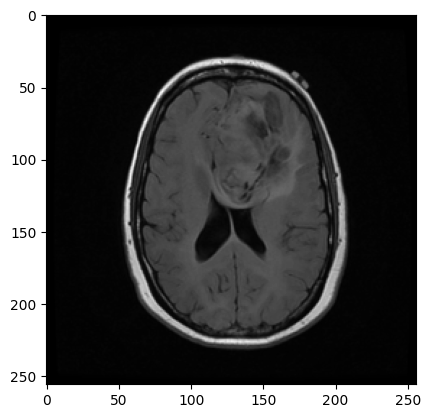

In [3]:
image = cv2.imread('./datasets/tumor_img/021.png')
plt.imshow(image[:,:,0], cmap='gray')
plt.show()


**4. 通过PIL库函数读取照片**

In [4]:
imagepil = Image.fromarray(image[:,:,0])

**5. 定义需要使用到的数据增强**

这里由于输入的图像已经是预处理之后保存下来的图像，因此只需要将图像从numpy格式变为tensor格式，方便之后的送入GPU进行加速

In [5]:
transform_process=transforms.Compose([
    transforms.ToTensor(),
])

**6. 数据预处理**

对于网络训练而言，输入图像的维度是（B,C,H,W），其中B表示 `batchsize`，是批量的大小；C 表示通道数，对于彩色图像而言是3；H和W表示图像的大小，在定义的数据增强中，H 和 W 在此处是256。然而直接读如图像，维度是（1，256，256）并没有 `batchsize` 的维度，因此需要通过 `unsqueeze(0)` 方法增加维度，其中0表示在第一个维度增加。通过此预处理操作，维度将变为（1，1，256，256）

下面一行代码分别执行了：通过 `transform_process(imagepil)` 将图像进行之前定义的数据增强操作；通过 `unsqueeze` 方法增加 `batchsize` 的维度；通过 `cuda()` ，放入 GPU 中进行加速

In [6]:
brain_slice = transform_process(imagepil).unsqueeze(0).cuda()

**7. 模型推理**

最终得到的预测结果是输出（pred）是一个预测掩码。对于二分类而言，表示预测成为前景的概率。

`model(img_tensor)` 表示将图像放入模型中，进行前向传输，模型的权重是之前网络训练出的结果，输出的维度是（B，C），B同样是batchsize，表示批量的大小；C 表示种类的数量，在此项目中输出的维度是（1，3）。通过 `squeeze()` 方法，表示将第一个维度删去，最终输出的维度是（3），表示对三个类预测的概率。

In [7]:
with torch.no_grad():
    pred = model(brain_slice).squeeze()

**8. 得到预测掩码**

通过模型预测出前景的概率是一个概率值的输出，数值大小在[0,1]中，但对于掩码结果而言，是一个0，1二值的图像，因此通过对于预测结果中概率大于0.5的表示称前景（1），概率小于0.5的表示成背景（0），获得二值掩码的结果，并进行可视化。

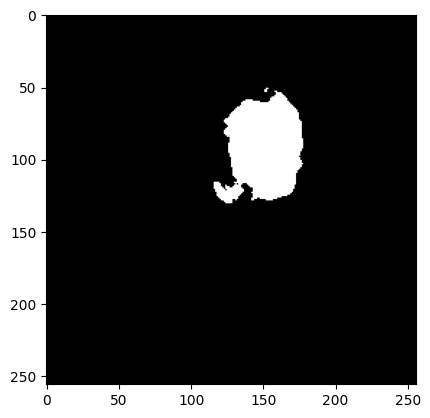

In [8]:
slice_mask_pred = torch.where(pred > 0.5, torch.ones_like(pred, dtype=torch.uint8), torch.zeros_like(pred, dtype=torch.uint8))
slice_mask_pred = slice_mask_pred.detach().cpu().numpy()
plt.imshow(slice_mask_pred, cmap='gray')
plt.show()

**9. 将掩码与原图重叠可视化**

将掩码和原图叠加显示，可以更好的定位肿瘤的位置。

我们编写了可视化函数`combined_show`

`combined_show(image, slice_mask_pred)`

* 将三维切片和肿瘤掩码叠加可视化
* 输入：
  * image：原始脑部切片图像
  * slice_mask_pred：通过网络预测的肿瘤掩码
* 输出：
  * matpltlib.pyplot可视化图像，肿瘤图像和掩码的叠加

In [9]:
def combined_show(image, mask):
    assert image.shape[:2] == mask.shape[:2]
    image_color = image.copy()
    index = np.where(mask == 1)
    image_color[index[0], index[1], :] = [255,255,255]
    vis_img = cv2.addWeighted(image, 0.6, image_color, 0.4, 0)
    return vis_img

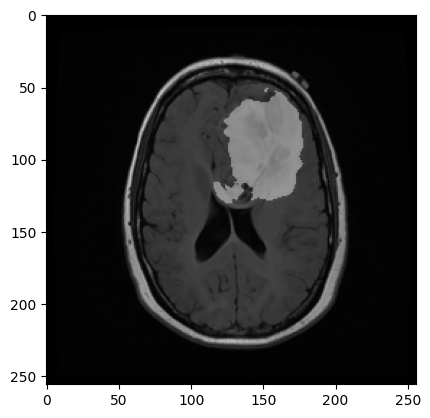

In [10]:
show_image = combined_show(image, slice_mask_pred)
plt.imshow(show_image)
plt.show()